## Recordings segments loader

In [1]:
import os
import json
from functools import reduce

# is_single_speaker_segment [VALIDATED]
# validates if a segment has a single speaker who belongs to the speakers list. 
def is_single_speaker_segment(segment, valid_speakers_ids = ['A', 'B']):
    return len(segment['speakers']) == 1 and segment['speakers'][0]['speaker_id'] in valid_speakers_ids

# is_valid_segment [VALIDATED]
# validates if a segment meets a maximum number of speakers,
# and that all the speakers in the segment belong to a list.
def is_valid_segment(segment, maximum_speakers_length = 2, valid_speakers_ids = ['A', 'B']):
    speakers_ids = [speaker['speaker_id'] for speaker in segment['speakers']]
    speakers_ids = list(set(speakers_ids))
    return len(speakers_ids) <= maximum_speakers_length and \
        all(speaker_id in valid_speakers_ids for speaker_id in speakers_ids)

# load_recordings_segments [VALIDATED]
# loads the recordings segments data from the .json files located in a directory 
def load_recordings_segments(directory, validation_function):
    filenames = [filename for filename in os.listdir(directory) if os.path.isfile(os.path.join(directory, filename))]
    filenames.sort()
    recordings_segments = {}
    recordings_length = len(filenames)
    recordings_count = 0
    segments_original = 0
    segments_filtered = 0
    for filename in filenames:
        recording_id = filename.split('.')[0]
        filepath = os.path.join(directory, filename)
        file = open(filepath, 'r')
        recordings_segments[recording_id] = [json.loads(line) for line in file.readlines()]
        file.close()
        segments_original += len(recordings_segments[recording_id])
        recordings_segments[recording_id] = list(filter(validation_function, recordings_segments[recording_id]))
        segments_filtered += len(recordings_segments[recording_id])
        recordings_count += 1
        print(directory + ' loading ' + str(recordings_count) + '/' + str(recordings_length), end = '\r')
    print(directory, 'loaded', str(recordings_count) + '/' + str(recordings_length) + ',', round(segments_filtered / segments_original, 2), 'segments left.')
    return recordings_segments

# speakers_get_indexes [VALIDATED]
# used to convert a (speakers_ids, index) list to a speakers_ids => [indexes] dictionary
def speakers_get_indexes(accumulator, speakers_tuple):
    speaker_ids, index = speakers_tuple
    speaker_ids = ','.join(speaker_ids)
    if speaker_ids in accumulator:
        accumulator[speaker_ids].append(index)
    else:
        accumulator[speaker_ids] = [index]
    return accumulator

# balance_segments [VALIDATED]
# balances the recording segments data to meet a minimum of speakers per recording,
# and a minimum of segments per speaker.
def balance_segments(recordings_segments,
                     minimum_speakers_length = 2,
                     minimum_speaker_segments = 3,
                     include_overlaps = False):
    new_recordings_segments = {}
    for recording_id in recordings_segments:
        recording_segments = recordings_segments[recording_id]
        # ----- Obtaining speakers indexes ----- #
        speakers_indexes = [(sorted(list(set([speaker['speaker_id'] for speaker in segment['speakers']]))), index) for index, segment in enumerate(recording_segments)]
        speakers_indexes = reduce(speakers_get_indexes, speakers_indexes, {})
        # ----- Removing overlaps ----- #
        if not include_overlaps:
            for speakers_ids in list(speakers_indexes.keys()):
                if len(speakers_ids.split(',')) > 1:
                    del speakers_indexes[speakers_ids]
        speakers_lengths = [(speakers_ids, len(speakers_indexes[speakers_ids])) for speakers_ids in speakers_indexes]
        speakers_lengths.sort(key = lambda x: x[1])
        speakers_lengths_min = speakers_lengths[0][1]
        if len(speakers_lengths) >= minimum_speakers_length and speakers_lengths_min >= minimum_speaker_segments:
            recording_indexes = []
            for speakers_ids in speakers_indexes:
                speakers_indexes[speakers_ids] = speakers_indexes[speakers_ids][:speakers_lengths_min]
                recording_indexes += speakers_indexes[speakers_ids]
            new_recordings_segments[recording_id] = [segment for index, segment in enumerate(recordings_segments[recording_id]) if index in recording_indexes]
    print('Recordings left: ' + str(len(new_recordings_segments)) + '/' + str(len(recordings_segments)))
    return new_recordings_segments

## Recordings dataset

In [2]:
from torch.utils.data import Dataset
import random
import numpy as np
import itertools

def generate_speaker_model(recording_segments,
                           speaker_indexes,
                           segments_length,
                           vector = 'ivectors',
                           selection = 'first',
                           indexes = []):
    #if segments_length > len(speaker_indexes):
    #    print('WARNING: there are less speaker indexes than segments.')
    if selection == 'first':
        selected_segments = [segment for index, segment in enumerate(recording_segments) if index in speaker_indexes[:segments_length]]
    elif selection == 'random':
        selected_segments = [recording_segments[index] for index in random.sample(speaker_indexes, segments_length if segments_length < len(speaker_indexes) else len(speaker_indexes))]
    elif selection == 'indexes':
        selected_segments = [recording_segments[index] for index in indexes]
    else:
        print('ERROR: unknown speaker model segments selection strategy.')
    selected_vectors = [np.asarray(segment[vector][0]['value']) for segment in selected_segments]
    return np.sum(selected_vectors, 0) / len(selected_vectors)
    

class Recordings_dataset(Dataset):
    def __init__(self,
                 recordings_segments,
                 recordings_ids = None,
                 vector = 'ivectors',
                 models_container_length = 2,
                 models_container_include_zeros = True,
                 models_container_include_overlaps = False,
                 models_generation_lengths = [3],
                 models_generation_selection = 'first',
                 balance_segments = True,
                 balance_segments_selection = 'copy'):
        # -----------------------------------------------------Saving input data----- #
        if recordings_ids is None:
            recordings_ids = [recording_id for recording_id in recordings_segments]
        self.recordings_ids = recordings_ids if isinstance(recordings_ids, list) else [recordings_ids]
        self.recordings_segments = {}
        for recording_id in self.recordings_ids:
            self.recordings_segments[recording_id] = recordings_segments[recording_id]
        self.vector = vector
        self.models_container_length = models_container_length
        self.models_container_include_zeros = models_container_include_zeros
        self.models_container_include_overlaps = models_container_include_overlaps
        self.models_generation_lengths = models_generation_lengths
        self.models_generation_selection = models_generation_selection
        self.balance_segments = balance_segments
        self.balance_segments_selection = balance_segments_selection
        # --------------------------------------------------------------------------- #
        self.recordings_data = {}
        # -------------------------------------------------- #
        self.recordings_map = []
        self.recordings_length = 0
        for recording_id in self.recordings_ids:
            self.recordings_data[recording_id] = {}
            recording_segments = self.recordings_segments[recording_id]
            recording_data = self.recordings_data[recording_id]
            # ----- Obtaining speakers indexes ----- #
            recording_data['speakers_indexes'] = [(sorted(list(set([speaker['speaker_id'] for speaker in segment['speakers']]))), index) for index, segment in enumerate(recording_segments)]
            recording_data['speakers_indexes'] = reduce(speakers_get_indexes, recording_data['speakers_indexes'], {})
            # ----- Balancing speakers segments ----- #
            recording_data['speakers_indexes_lengths_max'] = max([len(recording_data['speakers_indexes'][speakers_ids]) for speakers_ids in recording_data['speakers_indexes']])
            if self.balance_segments:
                if self.balance_segments_selection == 'copy':
                    for speakers_ids in recording_data['speakers_indexes']:
                        for i in range(recording_data['speakers_indexes_lengths_max'] - len(recording_data['speakers_indexes'][speakers_ids])):
                            index = random.choice(recording_data['speakers_indexes'][speakers_ids])
                            recording_segments.append(recording_segments[index])
                            recording_data['speakers_indexes'][speakers_ids].append(len(recording_segments) - 1)
                else:
                    print('ERROR: unknown balancing segments selection strategy.')
            # ----- Generating speakers models ----- #
            recording_data['speakers_models'] = {}
            for speakers_ids in recording_data['speakers_indexes']:
                recording_data['speakers_models'][speakers_ids] = {}
                for models_generation_length in models_generation_lengths:
                    speakers_model = generate_speaker_model(recording_segments, recording_data['speakers_indexes'][speakers_ids], models_generation_length, self.vector, self.models_generation_selection)
                    recording_data['speakers_models'][speakers_ids][models_generation_length] = [speakers_model]
            # ----- Generating permutations ----- #
            if self.models_container_include_zeros:
                recording_data['permutations'] = list(itertools.permutations(list(recording_data['speakers_models'].keys()) \
                + ['0' for i in range(self.models_container_length)], self.models_container_length))
            else:
                recording_data['permutations'] = list(itertools.permutations(list(recording_data['speakers_models'].keys()), self.models_container_length))
            recording_data['permutations'] = list(set(recording_data['permutations']))
            recording_data['permutations'].sort()
            if not self.models_container_include_overlaps:
                recording_data['permutations'] = [permutation for permutation in recording_data['permutations'] if all(len(speakers_ids.split(',')) == 1 for speakers_ids in permutation)]
            # -------------------------------------------------- #
            recording_data['permutations_map'] = []
            recording_data['permutations_length'] = 0
            for index, permutation in enumerate(recording_data['permutations']):
                speakers_models_length = int(np.prod([np.sum([len(recording_data['speakers_models'][speakers_ids][models_generation_length]) for models_generation_length in recording_data['speakers_models'][speakers_ids]]) for speakers_ids in permutation if speakers_ids != '0']))
                recording_data['permutations_map'].append((recording_data['permutations_length'], recording_data['permutations_length'] + speakers_models_length - 1, index))
                recording_data['permutations_length'] += speakers_models_length
            recording_data['length'] = len(recording_segments) * recording_data['permutations_length']
            self.recordings_map.append((self.recordings_length, self.recordings_length + recording_data['length'] - 1, recording_id))
            self.recordings_length += recording_data['length']
    def __len__(self):
        return self.recordings_length
    def __getitem__(self, idx):
        recording_limits = list(filter(lambda recording_limits: recording_limits[0] <= idx and idx <= recording_limits[1], self.recordings_map))[0]
        recording_idx = idx - recording_limits[0]
        recording_id = recording_limits[2]
        recording_data = self.recordings_data[recording_id]
        
        segment_index, segment_idx = divmod(recording_idx, recording_data['permutations_length'])
        segment = self.recordings_segments[recording_id][segment_index]
        vector = np.asarray(segment[self.vector][0]['value'])
        
        permutation_limits = list(filter(lambda permutation_limits: permutation_limits[0] <= segment_idx and segment_idx <= permutation_limits[1], recording_data['permutations_map']))[0]
        permutation_idx = segment_idx - permutation_limits[0]
        permutation_index = permutation_limits[2]
        permutation = recording_data['permutations'][permutation_index]
        
        speakers_models_lengths = [np.sum([len(recording_data['speakers_models'][speakers_ids][models_generation_length]) for models_generation_length in recording_data['speakers_models'][speakers_ids]])  if speakers_ids != '0' else 1 for speakers_ids in permutation]
        models_container = []
        model_index = permutation_idx
        for i, length_i in enumerate(speakers_models_lengths):
            if i != len(speakers_models_lengths) - 1:
                model_index, remainder = divmod(model_index, np.sum(speakers_models_lengths[i + 1:]))
            else:
                model_index = remainder
            models_container.append(recording_data['speakers_models'][permutation[i]][self.models_generation_lengths[model_index]][0] if permutation[i] != '0' else np.random.uniform(-0.1, 0.1, len(vector)))
        
        models_weigths = np.asarray([len(recording_data['speakers_indexes'][speakers_ids]) if speakers_ids != '0' else recording_data['speakers_indexes_lengths_max'] for speakers_ids in permutation])
        models_weigths_sum = np.sum(models_weigths)
        models_weigths = np.ones(len(models_weigths)) - models_weigths / models_weigths_sum
        
        targets_ids = [speaker['speaker_id'] for speaker in segment['speakers']]
        
        x = [vector] + models_container
        if self.models_container_include_overlaps:
            targets_ids = ','.join(sorted(list(set(targets_ids))))
            y = np.asarray([speakers_ids == targets_ids for speakers_ids in permutation], dtype = float)
        else:
            y = np.asarray([speaker_id in targets_ids for speaker_id in permutation], dtype = float) / len(targets_ids)
        z = models_weigths
        
        return x, y, z

## Live plotter

In [3]:
# %load live_graph.py
%matplotlib notebook
import matplotlib.pyplot as plt

class Live_graph:
    def __init__(self, validation_threshold):
        self.plt_count = -1
        self.validation_threshold = validation_threshold
        self.plt_thr = ([self.plt_count], [self.validation_threshold])
        self.plt_loss = ([self.plt_count], [1])
        self.plt_valid = ([self.plt_count], [1])
        self.plt_test = ([self.plt_count], [1])
        self.fig = plt.figure()
        self.ax = self.fig.add_subplot()
        self.line0, = self.ax.plot(self.plt_thr[0], self.plt_thr[1], 'k--', label = 'Threshold') # Threshold line
        self.line1, = self.ax.plot(self.plt_loss[0], self.plt_loss[1], '--', label = 'Training') # Training loss
        self.line2, = self.ax.plot(self.plt_valid[0], self.plt_valid[1], label = 'Validation')   # Validation loss
        self.line3, = self.ax.plot(self.plt_test[0], self.plt_test[1], label = 'Test')           # Test loss
        self.ax.set_xlabel('Epoch')
        self.ax.set_ylabel('Loss')
        self.ax.legend()
        self.ax.set_xlim(-1, 0)
        self.ax.set_ylim(0, 0.5)
        self.fig.canvas.draw()
        self.fig.canvas.flush_events()
    def step(self, training, validation, test = -1):
        self.plt_count += 1
        self.plt_thr[0].append(self.plt_count)
        self.plt_thr[1].append(self.validation_threshold)
        self.plt_loss[0].append(self.plt_count)
        self.plt_loss[1].append(training)
        self.plt_valid[0].append(self.plt_count)
        self.plt_valid[1].append(validation)
        self.plt_test[0].append(self.plt_count)
        self.plt_test[1].append(test)
        self.line0.set_xdata(self.plt_thr[0])
        self.line0.set_ydata(self.plt_thr[1])
        self.line1.set_xdata(self.plt_loss[0])
        self.line1.set_ydata(self.plt_loss[1])
        self.line2.set_xdata(self.plt_valid[0])
        self.line2.set_ydata(self.plt_valid[1])
        self.line3.set_xdata(self.plt_test[0])
        self.line3.set_ydata(self.plt_test[1])
        self.ax.set_xlim(0, self.plt_count + 1)
        self.fig.canvas.draw()
        self.fig.canvas.flush_events()

## DNN model

In [4]:
import torch.nn as nn

class Net(nn.Module):
    def __init__(self, models_container_length, vector_length):
        super().__init__()
        n = models_container_length
        m = vector_length
        self.cnn1 = nn.Sequential(
            nn.Conv1d((n + 1), n ** 3, 3),
            nn.ReLU(),
            nn.Conv1d(n ** 3, n ** 2, 3),
            nn.ReLU(),
            nn.Conv1d(n ** 2, n, 3),
            nn.ReLU(),
        )
        self.fc1 = nn.Sequential(
            nn.Linear(n * (m - 6), n * 16),
            nn.ReLU(),
            nn.Linear(n * 16, n * 4),
            nn.ReLU(),
            nn.Linear(n * 4, n),
            nn.Sigmoid(),
        )
        
    def forward(self, input):
        x = torch.stack(input, 1)
        x = self.cnn1(x)
        x = x.view(x.shape[0], -1)
        x = self.fc1(x)
        return x

## DNN trainer

In [57]:
import torch
from torch.utils.data import DataLoader, random_split
import torch.optim as optim

class Trainer:
    def __init__(self):
        if torch.cuda.is_available():
            self.device = torch.device('cuda:0')
        else:
            self.device = torch.device('cpu')
    def get_net(self,
                recordings_segments,
                recordings_ids = None,
                vector = 'ivectors',
                vector_length = 128,
                models_container_length = 2,
                models_container_include_zeros = True,
                models_container_include_overlaps = False,
                models_generation_lengths = [3],
                models_generation_selection = 'first',
                balance_segments = True,
                balance_segments_selection = 'copy',
                batch_size = 16,
                num_workers = 8,
                test_recordings_segments = None):
        
        if recordings_ids is None:
            recordings_ids = [recording_id for recording_id in recordings_segments]
        self.recordings_ids = recordings_ids if isinstance(recordings_ids, list) else [recordings_ids]

        train_dataset = Recordings_dataset(recordings_segments,
                                           recordings_ids, 
                                           vector,
                                           models_container_length,
                                           models_container_include_zeros,
                                           models_container_include_overlaps,
                                           models_generation_lengths,
                                           models_generation_selection,
                                           balance_segments,
                                           balance_segments_selection)

        train_length = int(len(train_dataset) * 0.7)
        valid_length = len(train_dataset) - train_length

        train_dataset, valid_dataset = random_split(train_dataset, [train_length, valid_length])

        train_dataloader = DataLoader(train_dataset, batch_size = batch_size, shuffle=True, num_workers = num_workers)
        valid_dataloader = DataLoader(valid_dataset, batch_size = batch_size, num_workers = num_workers)
        
        if test_recordings_segments is not None:
            test_recordings_ids = [recording_id for recording_id in test_recordings_segments]
            test_dataset = Recordings_dataset(test_recordings_segments,
                                              test_recordings_ids,
                                              vector,
                                              models_container_length,
                                              models_container_include_zeros,
                                              models_container_include_overlaps,
                                              models_generation_lengths,
                                              models_generation_selection,
                                              balance_segments,
                                              balance_segments_selection)
            test_dataloader = DataLoader(test_dataset, batch_size = batch_size, num_workers = num_workers)

        net = Net(models_container_length, vector_length).to(self.device)
        optimizer = optim.Adam(net.parameters(), lr = 0.0001)

        epochs = 30
        validation_threshold = 0.07

        live_graph = Live_graph(validation_threshold)

        for epoch in range(epochs):
            train_losses = []
            for input, target, weigth in train_dataloader:
                input = [tensor.to(self.device, non_blocking = True).float() for tensor in input]
                target = target.to(self.device, non_blocking = True).float()
                weigth = weigth.to(self.device, non_blocking = True).float()

                criterion = nn.BCELoss(weigth)
                net.zero_grad()
                output = net(input)
                loss = criterion(output, target)
                loss.backward()
                optimizer.step()

                train_losses.append(loss.data)
                print('train: ' + str(len(train_losses)) + '/' + str(len(train_dataloader)) + '          ', end = '\r')
            train_loss = np.sum(train_losses) / len(train_losses)

            with torch.no_grad():
                validation_losses = []
                for input, target, weigth in valid_dataloader:
                    input = [tensor.to(self.device, non_blocking = True).float() for tensor in input]
                    target = target.to(self.device, non_blocking = True).float()
                    weigth = weigth.to(self.device, non_blocking = True).float()

                    criterion = nn.BCELoss(weigth)
                    output = net(input)
                    loss = criterion(output, target)
                    validation_losses.append(loss.data)
                    print('validation: ' + str(len(validation_losses)) + '/' + str(len(valid_dataloader)) + '          ', end = '\r')
                validation_loss = np.sum(validation_losses) / len(validation_losses)
                
                test_loss = -1
                if test_recordings_segments is not None:
                    test_losses = []
                    for input, target, weigth in test_dataloader:
                        input = [tensor.to(self.device, non_blocking = True).float() for tensor in input]
                        target = target.to(self.device, non_blocking = True).float()
                        weigth = weigth.to(self.device, non_blocking = True).float()

                        criterion = nn.BCELoss(weigth)
                        output = net(input)
                        loss = criterion(output, target)
                        test_losses.append(loss.data)
                        print('test: ' + str(len(test_losses)) + '/' + str(len(test_dataloader)) + '          ', end = '\r')
                    test_loss = np.sum(test_losses) / len(test_losses)

            live_graph.step(train_loss, validation_loss, test_loss)

            if validation_loss <= validation_threshold:
                print('Done training.')
                break
        return net

In [58]:
# %load md_eval.py
import subprocess
import re

def md_eval(ref_filepath, res_filepath, save_filepath = None):
    bin = '../../../../tools/sctk-2.4.10/src/md-eval/md-eval.pl'
    p = subprocess.Popen([bin, '-r', ref_filepath, '-s', res_filepath], stdin=subprocess.PIPE, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
    output, err = p.communicate()
    rc = p.returncode
    if rc == 0:
        output = output.decode("utf-8")
        if save_filepath is not None:
            file = open(save_filepath, 'w')
            file.write(output)
            file.close()
        lines =  output.split('\n')
        derLine = [line for line in lines if 'OVERALL SPEAKER DIARIZATION ERROR' in line][0]
        return float(re.findall('\d+\.\d+', derLine)[0])
    else:
        exit('md-eval.pl fail')

In [59]:
def eer(res_filepath):
    bin = '../eer_score.sh'
    p = subprocess.Popen([bin, res_filepath], stdin=subprocess.PIPE, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
    output, err = p.communicate()
    rc = p.returncode
    if rc == 0:
        output = output.decode("utf-8")
        return float(output)
    else:
        exit('eer_score.sh fail')

In [60]:
def plda_score(ref_vector, test_vector, plda_filepath):
    ref_string = str(list(ref_vector)).replace(',', '').replace('[', '[ ').replace(']', ' ]')
    test_string = str(list(test_vector)).replace(',', '').replace('[', '[ ').replace(']', ' ]')

    bin = '../plda_score.sh'
    p = subprocess.Popen([bin, plda_filepath, ref_string, test_string], stdin=subprocess.PIPE, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
    output, err = p.communicate()
    rc = p.returncode
    if rc == 0:
        lines =  output.decode("utf-8").split('\n')
        pldaLine = [line for line in lines if 'reference test' in line][0]
        return float(re.findall('\d+\.\d+', pldaLine)[0])
    else:
        print(err)
        exit('plda_socre.sh fail')

## Tracking tester

In [61]:
def tracking_tester(recordings_segments,
                    recordings_ids = None,
                    scoring_function = None,
                    groundtruth_filepath = '',
                    groundtruth_valid_speakers_ids = ['A', 'B'],
                    vector = 'ivectors',
                    models_container_length = 2,
                    models_container_include_overlaps = False,
                    models_generation_length = 3,
                    models_generation_selection = 'first'):

    if recordings_ids is None:
        recordings_ids = [recording_id for recording_id in recordings_segments]
    recordings_ids = recordings_ids if isinstance(recordings_ids, list) else [recordings_ids]
    recordings_ids.sort()
    
    results = {}
    results_reduced = {}
    results_rttm = ''
    results_scores = {}
    results_eer = ''
    for recording_id in recordings_ids:
        recording_dataset = Recordings_dataset(recordings_segments,
                                               recording_id,
                                               vector = vector,
                                               models_container_length = models_container_length,
                                               models_container_include_zeros = False,
                                               models_container_include_overlaps = models_container_include_overlaps,
                                               models_generation_lengths = [models_generation_length],
                                               models_generation_selection = models_generation_selection,
                                               balance_segments = False,
                                               balance_segments_selection = 'copy')
        speakers_models = recording_dataset.recordings_data[recording_id]['speakers_models']
        speakers_ids = [speakers_ids for speakers_ids in speakers_models]
        models_container = [speakers_models[speakers_ids][models_generation_length][0] for speakers_ids in speakers_models if models_container_include_overlaps or len(speakers_ids.split(',')) == 1]
        for i in range(models_container_length - len(models_container)):
            models_container.append(np.random.uniform(-0.1, 0.1, len(models_container[0])))
        # At this point there is no information about the speaker identity, only the model
        results[recording_id] = []
        results_scores[recording_id] = []
        for segment in recordings_segments[recording_id]:
            segment_vector = np.asarray(segment[vector][0]['value'])
            scores = scoring_function(segment_vector, models_container)
            targets_ids = [speaker['speaker_id'] for speaker in segment['speakers']]
            targets_ids.sort()
            labels = ['target' if targets_ids == sorted(speaker_id.split(',')) else 'nontarget' for speaker_id in speakers_ids]
            scores_labels = list(zip(scores, labels))
            results_scores[recording_id].append(scores_labels)
            index = np.argmax(scores)
            results[recording_id].append({ 'begining': segment['begining'], 'ending': segment['ending'], 'speaker_id': index })
            if len(results[recording_id]) > 2:
                if results[recording_id][len(results[recording_id]) - 1]['speaker_id'] == results[recording_id][len(results[recording_id]) - 3]['speaker_id']:
                    if results[recording_id][len(results[recording_id]) - 1]['speaker_id'] != results[recording_id][len(results[recording_id]) - 2]['speaker_id']:
                        results[recording_id][len(results[recording_id]) - 2]['speaker_id'] = results[recording_id][len(results[recording_id]) - 1]['speaker_id']
                        results[recording_id][len(results[recording_id]) - 1]['modified'] = True
        results_reduced[recording_id] = []
        last_speaker_id = -1
        last_speaker = { 'begining': 0, 'ending': 0, 'speaker_id': -1 }
        for segment in results[recording_id] + [{ 'begining': 0, 'ending': 0, 'speaker_id': -1 }]:
            begining = segment['begining']
            ending = segment['ending']
            speaker_id = segment['speaker_id']
            if last_speaker_id != speaker_id:
                if last_speaker_id != -1:
                    results_reduced[recording_id].append(last_speaker)
                last_speaker_id = speaker_id
                last_speaker = { 'begining': begining, 'ending': ending, 'speaker_id': speaker_id }
            else:
                if begining <= last_speaker['ending']:
                    last_speaker['ending'] = ending
                else:
                    if last_speaker_id != -1:
                        results_reduced[recording_id].append(last_speaker)
                    last_speaker_id = speaker_id
                    last_speaker = { 'begining': begining, 'ending': ending, 'speaker_id': speaker_id }
        for scores_labels in results_scores[recording_id]:
            for score_label in scores_labels:
                result_eer = '{:f}'.format(score_label[0]) + ' ' + score_label[1]
                results_eer += result_eer + '\n'
        for segment in results_reduced[recording_id]:
            result_rttm = 'SPEAKER ' + recording_id + ' 0 ' + str(segment['begining']) + ' ' + str(round(segment['ending'] - segment['begining'], 2)) + ' <NA> <NA> ' + str(segment['speaker_id']) + ' <NA> <NA>'
            results_rttm += result_rttm + '\n'

    file = open(groundtruth_filepath, 'r')
    groundtruth_rttm = ''.join([line for line in file.readlines() if (line.split(' ')[1] in recordings_ids) and \
                    (line.split(' ')[7] in ['A', 'B'])])
    file.close()
    
    !mkdir -p tmp
    
    file = open('tmp/results.eer', 'w')
    file.write(results_eer)
    file.close()
    
    file = open('tmp/groundtruth.rttm', 'w')
    file.write(groundtruth_rttm)
    file.close()
    
    file = open('tmp/results.rttm', 'w')
    file.write(results_rttm)
    file.close()

    print(eer('notebooks/tmp/results.eer'))
    return md_eval('tmp/groundtruth.rttm', 'tmp/results.rttm')

## Loading recordings segments

In [62]:
a_directory = '../exp/pre_norm/callhome1/json'
b_directory = '../exp/pre_norm/callhome2/json'
maximum_speakers_length = 2
valid_speakers_ids = ['A', 'B']
include_overlaps = False
vector = 'ivectors'
vector_length = 128
models_container_length = 2
models_container_include_zeros = True
models_container_include_overlaps = False
models_generation_length = 3
models_generation_selection = 'first'
balance_segments_selection = 'copy'
batch_size = 32

In [63]:
a_recordings_segments = load_recordings_segments(a_directory,
                                                 lambda segment: is_valid_segment(segment, maximum_speakers_length, valid_speakers_ids))
b_recordings_segments = load_recordings_segments(b_directory,
                                                 lambda segment: is_valid_segment(segment, maximum_speakers_length, valid_speakers_ids))

../exp/pre_norm/callhome1/json loaded 249/249, 0.74 segments left.
../exp/pre_norm/callhome2/json loaded 250/250, 0.77 segments left.


Recordings left: 246/249


<IPython.core.display.Javascript object>


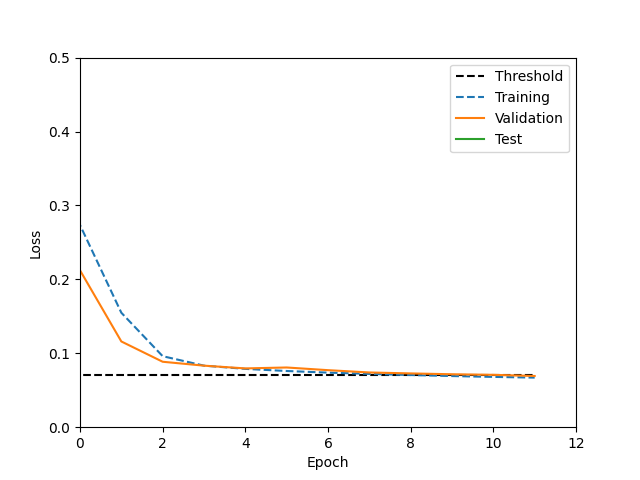

Done training.29/1029          


In [64]:
a_trainer = Trainer()
a_net = a_trainer.get_net(balance_segments(a_recordings_segments, 
                                           maximum_speakers_length,
                                           models_generation_length,
                                           include_overlaps),
                          vector = vector,
                          vector_length = vector_length,
                          models_container_length = models_container_length,
                          models_container_include_zeros = models_container_include_zeros,
                          models_container_include_overlaps = models_container_include_overlaps,
                          models_generation_lengths = [models_generation_length],
                          models_generation_selection = models_generation_selection,
                          balance_segments_selection = balance_segments_selection,
                          batch_size = batch_size)

In [65]:
def net_selector(vector, models_container, net):
    if torch.cuda.is_available():
        device = torch.device('cuda:0')
    else:
        device = torch.device('cpu')
    with torch.no_grad():
        input = [torch.Tensor([nparray]).to(device, non_blocking = True).float() for nparray in [vector] + models_container]
        output = net(input)
        return output.cpu().data.numpy()[0]
    
def plda_selector(vector, models_container, plda_filepath):
    return [plda_score(ref_vector, vector, plda_filepath) for ref_vector in models_container]

In [66]:
b_recordings_segments = load_recordings_segments(b_directory,
                                                 lambda segment: is_single_speaker_segment(segment, ['A', 'B']))

../exp/pre_norm/callhome2/json loaded 250/250, 0.7 segments left.


In [67]:
tracking_tester(b_recordings_segments,
                scoring_function = lambda vector, models_container: net_selector(vector, models_container, a_net),
                groundtruth_filepath = '../data/callhome2_1.0_0.5.rttm',
                groundtruth_valid_speakers_ids = ['A', 'B'],
                vector = vector,
                models_container_length = models_container_length,
                models_container_include_overlaps = models_container_include_overlaps,
                models_generation_length = models_generation_length,
                models_generation_selection = models_generation_selection)

6.498


7.16

In [16]:
tracking_tester(b_recordings_segments,
                scoring_function = lambda vector, models_container: plda_selector(vector,
                                                                                  models_container,
                                                                                  'exp/plda/callhome1/ivectors.plda'),
                groundtruth_filepath = '../data/callhome2_1.0_0.5.rttm',
                groundtruth_valid_speakers_ids = ['A', 'B'],
                vector = vector,
                models_container_length = models_container_length,
                models_container_include_overlaps = models_container_include_overlaps,
                models_generation_length = models_generation_length,
                models_generation_selection = models_generation_selection)

19.27


8.84